In [11]:
import tensorflow as tf
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from math import floor, ceil, pi
import scipy.misc
import glob

In [12]:
def get_image_paths():
    folder = "./value_reading/gauges/"
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for  file in files]
    return files

In [13]:
X_img_paths = get_image_paths()
print(X_img_paths[:])

['./value_reading/gauges//gauge_-0.0.png', './value_reading/gauges//gauge_-0.1.png', './value_reading/gauges//gauge_-0.2.png', './value_reading/gauges//gauge_-0.3.png', './value_reading/gauges//gauge_-0.4.png', './value_reading/gauges//gauge_-0.5.png', './value_reading/gauges//gauge_-0.6.png', './value_reading/gauges//gauge_-0.7.png', './value_reading/gauges//gauge_-0.8.png', './value_reading/gauges//gauge_-0.9.png', './value_reading/gauges//gauge_-1.0.png', './value_reading/gauges//gauge_0.1.png', './value_reading/gauges//gauge_0.2.png', './value_reading/gauges//gauge_0.3.png', './value_reading/gauges//gauge_0.4.png', './value_reading/gauges//gauge_0.5.png', './value_reading/gauges//gauge_0.6.png', './value_reading/gauges//gauge_0.7.png', './value_reading/gauges//gauge_0.8.png', './value_reading/gauges//gauge_0.9.png', './value_reading/gauges//gauge_1.0.png', './value_reading/gauges//gauge_1.1.png', './value_reading/gauges//gauge_1.2.png', './value_reading/gauges//gauge_1.3.png', './v

In [14]:
def tf_resize_img(X_img_file_paths, img_shape=224):
    X_data = []

# Individually resize image
    for index, file_path in enumerate(X_img_file_paths):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, size=[img_shape, img_shape])
        img = img/225.
        X_data.append(img)

    X_data = np.array(X_data, dtype=np.float32)
    return X_data

In [15]:
X_imgs = tf_resize_img(X_img_paths[:])
print(X_imgs.shape)

(41, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


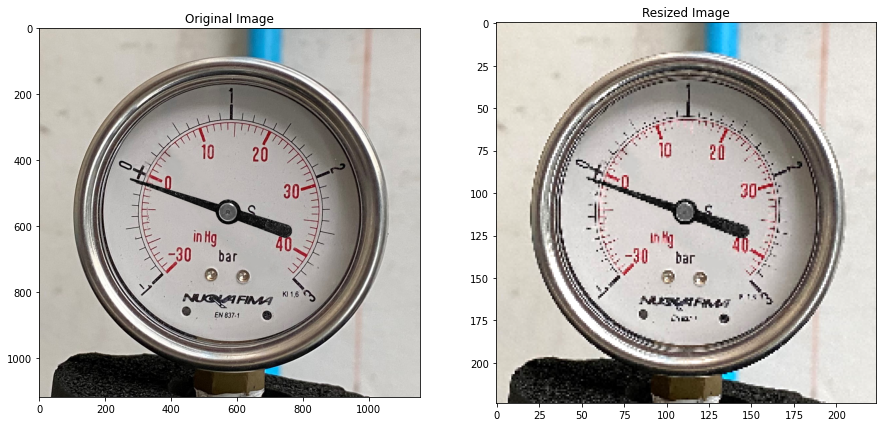

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[1])[:,:,:3])
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[1])
plt.title("Resized Image")
plt.show()

In [17]:
X_imgs[0].shape

(224, 224, 3)

### Scaling

In [18]:
def central_scale_images(X_imgs, scales, img_shape=224):
    boxes = np.zeros((len(scales), 4), dtype=np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype=np.float32)
    box_ind = np.zeros(len(scales), dtype=np.int32)
    crop_size = np.array([img_shape, img_shape], dtype=np.int32)

    X_scale_data= []
    for img_data in X_imgs:
        batch_img = tf.expand_dims(img_data, axis=0) # expand dimension of input image to 4 dims
        tf_img = tf.image.crop_and_resize(batch_img, boxes, box_ind, crop_size) # require 4 dims input
        X_scale_data.extend(tf_img)

    X_scale_data = np.array(X_scale_data, dtype=np.float32)
    return X_scale_data

In [19]:
scale_imgs = central_scale_images(X_imgs[:], [0.90, 0.75, 0.60])
print(scale_imgs.shape)

(123, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Scale=0.60')

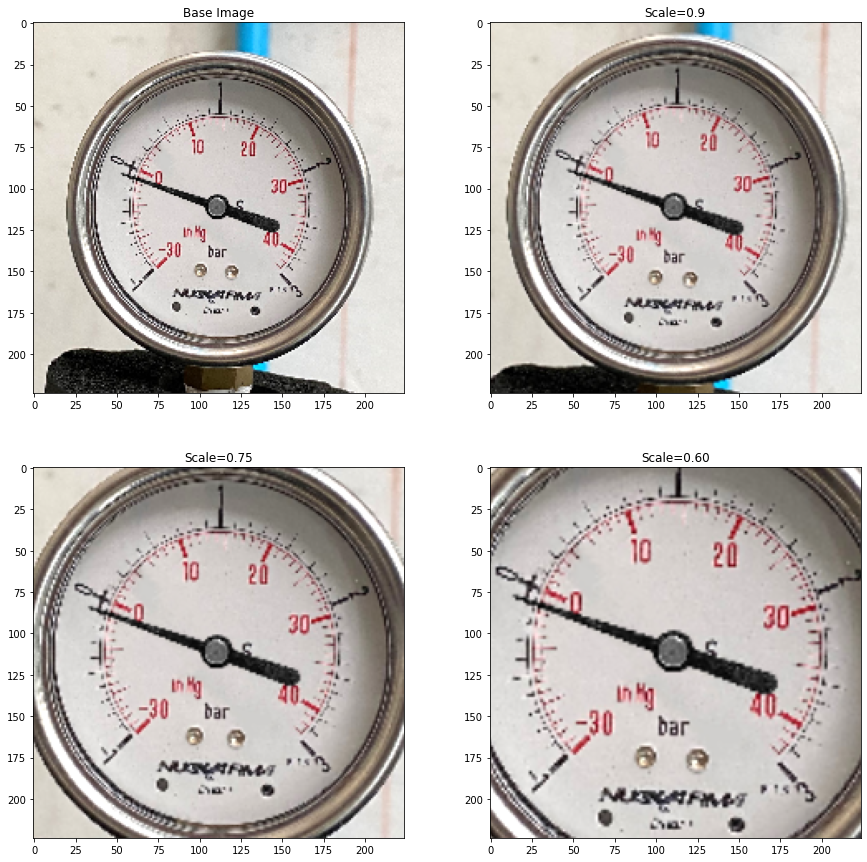

In [20]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(X_imgs[1])
plt.title("Base Image")
plt.subplot(2,2,2)
plt.imshow(scale_imgs[3])
plt.title("Scale=0.9")
plt.subplot(2,2,3)
plt.imshow(scale_imgs[4])
plt.title("Scale=0.75")
plt.subplot(2,2,4)
plt.imshow(scale_imgs[5])
plt.title("Scale=0.60")

### Translation

In [21]:
IMAGE_SIZE = 224

In [22]:
def get_translate_parameter(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    elif index == 3: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE
    elif index == 4: # Translate left 10 percent
        offset = np.array([0.0, 0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.9 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 5: # Translate right 10 percent
        offset = np.array([0.0, -0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE 
    elif index == 6: # Translate top 10 percent
        offset = np.array([0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.9 * IMAGE_SIZE))  
    elif index == 7: # Translate bottom 10 percent
        offset = np.array([-0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        h_end = IMAGE_SIZE      
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype=np.float32)
    n_translates=8
    X_translated_arr = []

    for i in range(n_translates):
        X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        X_translated.fill(1.0) # filling background color
        base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameter(i)
        offsets[:, :] = base_offset
        glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
        X_translated[:, h_start: h_start + size[0],
                     w_start: w_start + size[1], :] = glimpses
        X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype=np.float32)
    return X_translated_arr

In [23]:
translated_imgs = translate_images(X_imgs[:])
print(translated_imgs.shape)

(328, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


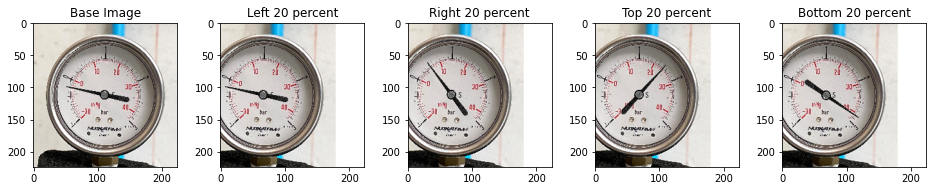

In [24]:
gs =  gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

### Rotation

In [25]:
def rotate_image(X_imgs):
    X_rotate = []
    for img in X_imgs:
        for i in range(3):
            rotated_img = tf.image.rot90(img, k=i+1)
            X_rotate.append(rotated_img)
    X_rotate = np.array(X_rotate, dtype=np.float32)
    return X_rotate

In [26]:
rotated_imgs = rotate_image(X_imgs[:])
print(rotated_imgs.shape)

(123, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


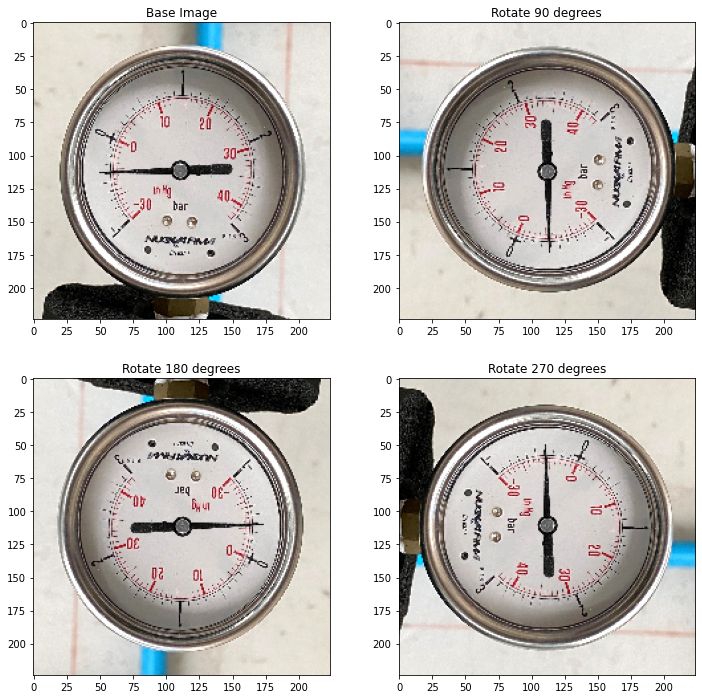

In [27]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(X_imgs[4])
plt.title("Base Image")
# 90 degrees
plt.subplot(2,2,2)
plt.imshow(rotated_imgs[12])
plt.title("Rotate 90 degrees")
# 180 degrees
plt.subplot(2,2,3)
plt.imshow(rotated_imgs[13])
plt.title("Rotate 180 degrees")
# 270 degrees
plt.subplot(2,2,4)
plt.imshow(rotated_imgs[14])
plt.title("Rotate 270 degrees")
plt.show()

### Rotation finer angles

In [28]:
!pip install tensorflow-addons

In [29]:
import tensorflow_addons as tfa

In [30]:
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    for index in range(n_images):
        degree_angle = start_angle + index * iterate_at
        radian_value = degree_angle * pi / 180 # convert  to radian
        radian_arr = [radian_value] * len(X_imgs)
        rotated_imgs = tfa.image.rotate(X_imgs, radian_arr)
        X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype=np.float32)
    return X_rotate 

In [31]:
rotated_imgs = rotate_images(X_imgs[:1], -90, 90, 14)
print(rotated_imgs.shape)

(14, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

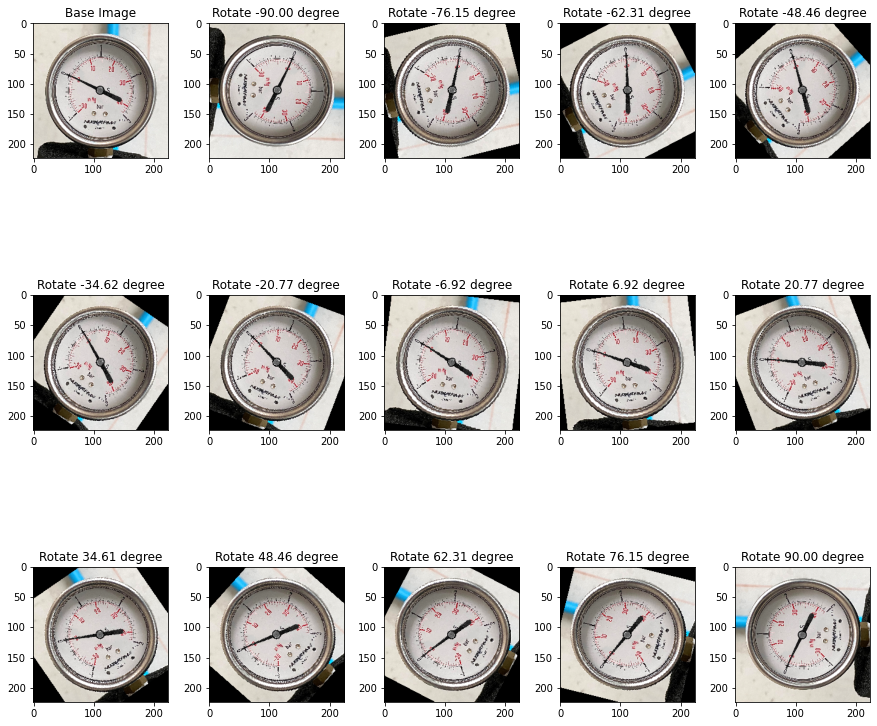

In [32]:
plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(X_imgs[0])
plt.title("Base Image")

for i in range(14):
    plt.subplot(gs[i+1])
    plt.imshow(rotated_imgs[i])
    plt.title("Rotate {:.2f} degree".format(-90 + 13.846 * i))
plt.show()

### Flipping

In [33]:
def flip_images(X_imgs):
    X_flip = []
    for img in X_imgs:
        tf_img1 = tf.image.flip_left_right(img)
        tf_img2 = tf.image.flip_up_down(img)
        tf_img3 = tf.image.transpose(img)
        X_flip.extend([tf_img1, tf_img2, tf_img3])
    X_flip = np.array(X_flip, dtype=np.float32)
    return X_flip

In [34]:
flipped_images = flip_images(X_imgs[:])
print(flipped_images.shape)

(123, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


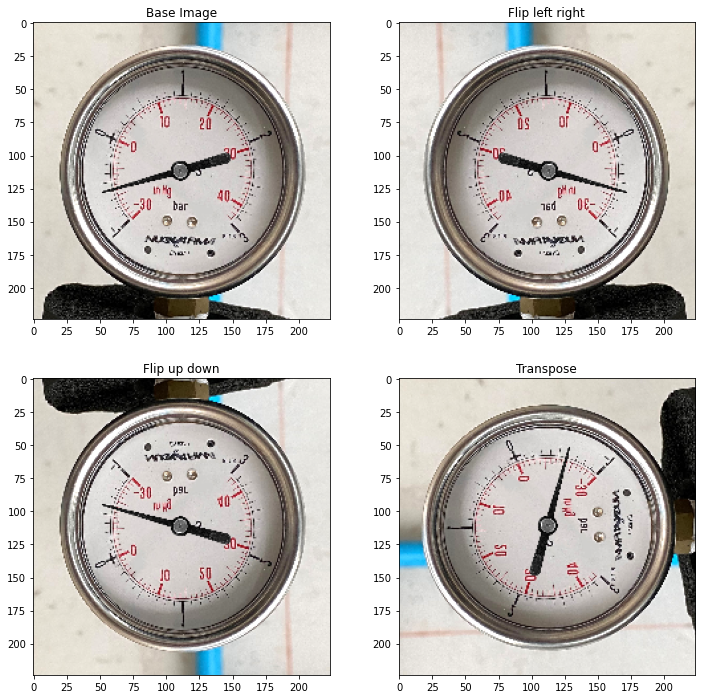

In [35]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(X_imgs[6])
plt.title("Base Image")
plt.subplot(2,2,2)
plt.imshow(flipped_images[18])
plt.title("Flip left right")
plt.subplot(2,2,3)
plt.imshow(flipped_images[19])
plt.title("Flip up down")
plt.subplot(2,2,4)
plt.imshow(flipped_images[20])
plt.title("Transpose")
plt.show()

### Adding Salt and Pepper noise

In [36]:
def add_salt_pepper_noise(X_imgs):
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1-salt_vs_pepper))

    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i-1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i-1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

    return X_imgs_copy

In [37]:
salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs[:])
print(salt_pepper_noise_imgs.shape)

(41, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


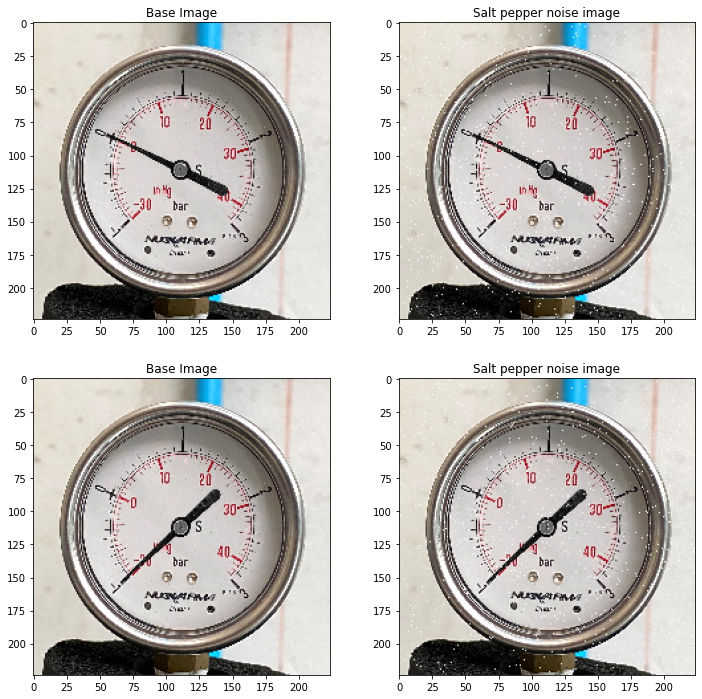

In [38]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(X_imgs[0])
plt.title("Base Image")
plt.subplot(2,2,2)
plt.imshow(salt_pepper_noise_imgs[0])
plt.title("Salt pepper noise image")
plt.subplot(2,2,3)
plt.imshow(X_imgs[10])
plt.title("Base Image")
plt.subplot(2,2,4)
plt.imshow(salt_pepper_noise_imgs[10])
plt.title("Salt pepper noise image")
plt.show()

### Lighting Condition

In [39]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution paramaters
    mean = 0
    var = 0.1
    sigma = var ** 0.5

    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)
        gaussian_img = cv.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    return gaussian_noise_imgs

In [40]:
gaussian_noise_imgs = add_gaussian_noise(X_imgs[:])
print(gaussian_noise_imgs.shape)

(41, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


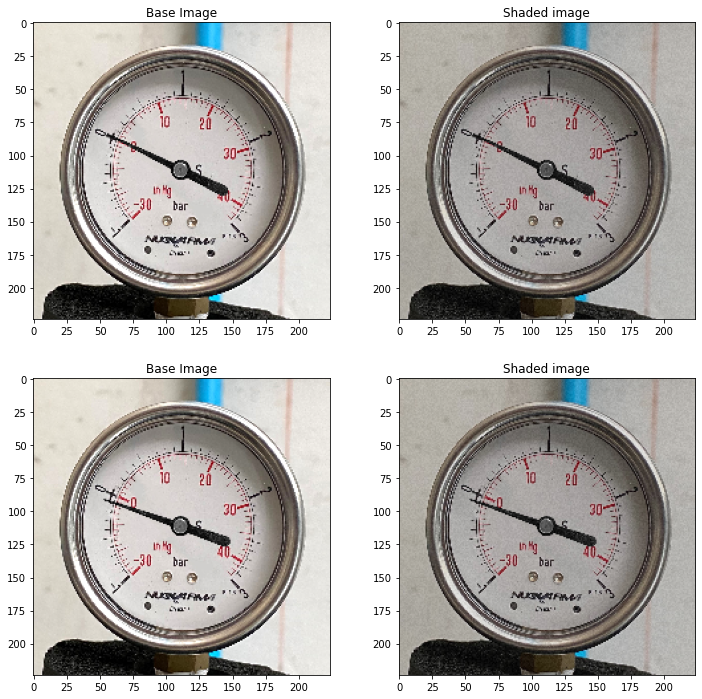

In [41]:
plt.figure(figsize = (12, 12))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[0])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gaussian_noise_imgs[0])
plt.title('Shaded image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[1])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(gaussian_noise_imgs[1])
plt.title('Shaded image')
plt.show()

### Perspective transform

In [42]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]),
                          (0.43 * imshape[1], 0.32 * imshape[0]),
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype=np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0],
                      [img_size[0] - offset, img_size[1]]])

    perspective_matrix = cv.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_tranform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv.warpPerspective(X_img, perspective_matrix,
                                    (X_img.shape[1], X_img.shape[0]),
                                    flags = cv.INTER_LINEAR)
    return warped_img


In [43]:
X_img = X_imgs[11]
perspective_img = perspective_tranform(X_img[:])
print(perspective_img.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


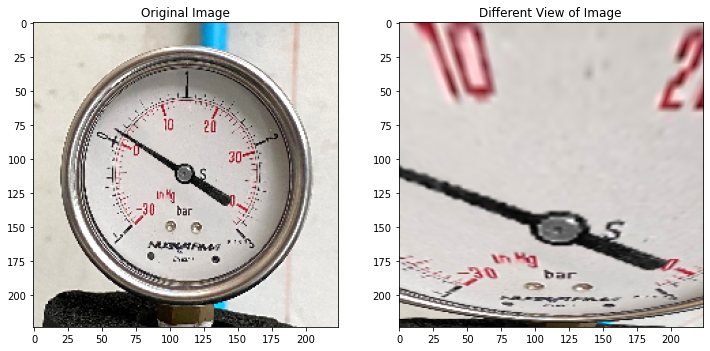

In [44]:
plt.figure(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_imgs[11])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_img)
plt.title('Different View of Image')
plt.show()

### Generate and save augmented images into class folder

In [45]:
filename = "gauge_0.png"
path = "./value_reading/tf_gauges/psi_{0}/{1}"

In [46]:
!pip install imageio

In [47]:
import imageio

In [48]:
def resize_image(i, X_img):
    file_resized = "gauge_resized.jpg"
    filename_resized = path.format(i, file_resized)
    # scipy.misc.imsave(filename_resized, X_img[0])
    imageio.imwrite(filename_resized, X_img[0])

In [49]:
def scaled_image(folder, img):
    scale = [0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.84,0.80,0.75,0.70,0.65,0.60]
    scaled_imgs = central_scale_images(img, scale)

    for i in range(0, len(scale)):
        filename = "gauge_scale_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        # scipy.misc.imsave(filepath, scaled_imgs[i])
        imageio.imwrite(filepath, scaled_imgs[i])

In [50]:
def translate_image(folder, img):
    translated_imgs = translate_images(img)

    for i in range(0, 8):
        filename = "gauge_translate_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        # scipy.misc.imsave(filepath, translated_imgs[i])
        imageio.imwrite(filepath, translated_imgs[i])

In [51]:
def rotate_general_image(folder, img):
    rotated = rotate_images(img, -90, 90, 14)

    for i in range(14):
        filename = "gauge_rotated_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        # scipy.misc.imsave(filepath, rotated[i])
        imageio.imwrite(filepath, rotated[i])

In [52]:
def flipped_image(folder, img):
    flipped = flip_images(img)

    for i in range(3):
        filename = "gauge_flipped_{0}.jpg".format(i)
        filepath = path.format(folder, filename)
        # scipy.misc.imsave(filepath, flipped[i])
        imageio.imwrite(filepath, flipped[i])

In [53]:
def salt_pepper(folder, img):
    salt = add_salt_pepper_noise(img)
    filepath = "gauge_salt_pepper.jpg"
    # scipy.misc.imsave(filepath, salt[0])
    imageio.imwrite(filepath, salt[0])

In [54]:
def lighting(folder, img):
    gaussian = add_gaussian_noise(img)
    filename = "gauge_gaussain.jpg"
    filepath = path.format(folder, filename)
    # scipy.misc.imsave(filepath, gaussian[0])
    imageio.imwrite(filepath, gaussian[0])

In [55]:
dirList = glob.glob("./value_reading/tf_gauges/*/*.png")
X_img_paths = ["{}".format(file) for file in dirList]

In [56]:
def exec_images(i, img):
    # Resized Image
    resize_image(i, img)
    # Scale 97% - 60%
    scaled_image(i, img)
    # Translate the images
    translate_image(i, img)
    # Rotate the image 
    rotate_general_image(i, img)
    # Flip the image
    flipped_image(i, img)
    # Add noise in pixels
    salt_pepper(i, img)
    # Lighting condition
    lighting(i, img)

In [57]:
for i in np.arange(-1, 3+0.1, 0.1):
  scale_num = "{:.1f}".format(i)
  X_img = path.format(scale_num, filename)
  X_resize = tf_resize_img([X_img])

  salt_pepper(i, X_resize)

Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

In [58]:
for i in np.arange(-1, 3+0.1, 0.1):
  scale_num = "{:.1f}".format(i)
  X_img = path.format(scale_num, filename)
  X_resize = tf_resize_img([X_img])

  exec_images(scale_num, X_resize)
  

Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1330370903015137]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1330732107162476]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1330000162124634]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1331197023391724]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1332899332046509]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333229541778564]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u